---

# Training a CNN to Classify Objects and Draw Bounding Boxes

### Required Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## The Object Detection Model

The model architecture below has several layers, but in exam point of view, we can create with simple `Feature Extraction Layers`. However, the `shared layers`, `bbox branch` and output will remain the same.

In [2]:
class ObjectDetectionModel:
    def __init__(self, num_classes=4, input_shape=(128, 128, 3)):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.class_names = ['apple', 'banana', 'orange', 'mixed']
        self.model = self._build_model()

    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)

        # Feature extraction layers
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)

        # Shared features
        shared = layers.Dense(256, activation='relu')(x)
        shared = layers.Dropout(0.3)(shared)

        # Classification branch
        class_branch = layers.Dense(128, activation='relu')(shared)
        class_branch = layers.Dropout(0.2)(class_branch)
        class_output = layers.Dense(
            self.num_classes,
            activation='softmax',
            name='classification'
        )(class_branch)

        # Bounding box regression branch with better initialization
        bbox_branch = layers.Dense(128, activation='relu')(shared)
        bbox_branch = layers.Dropout(0.2)(bbox_branch)
        bbox_branch = layers.Dense(64, activation='relu')(bbox_branch)

        # Use linear activation for bbox and apply sigmoid manually for better gradient flow
        bbox_raw = layers.Dense(4, activation='linear', name='bbox_raw')(bbox_branch)
        bbox_output = layers.Activation('sigmoid', name='bbox_regression')(bbox_raw)

        model = models.Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model

    def compile_model(self):
        """Compile with loss weighting and learning rate"""
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # learning rate

            # Notice that we use loss for both classification and bounding box regression here
            loss={
                'classification': 'sparse_categorical_crossentropy',
                'bbox_regression': 'huber'  # More robust to outliers than MSE
            },
            loss_weights={
                'classification': 10.0,  # Increased classification importance
                'bbox_regression': 1.0   # Reduced bbox weight
            },
            metrics={
                'classification': ['accuracy'],
                'bbox_regression': ['mae']
            }
        )

## Parsing the XML Annotations

In [3]:
def parse_xml_annotation(xml_path):
      tree = ET.parse(xml_path)
      root = tree.getroot()

      # Get image dimensions with better error handling
      size = root.find('size')
      width = int(size.find('width').text) if size.find('width') is not None and size.find('width').text != '0' else None
      height = int(size.find('height').text) if size.find('height') is not None and size.find('height').text != '0' else None

      # Get object information
      obj = root.find('object')
      if obj is None:
          return None, None, None

      class_name = obj.find('name').text

      # Get bounding box coordinates
      bbox = obj.find('bndbox')
      xmin = int(bbox.find('xmin').text)
      ymin = int(bbox.find('ymin').text)
      xmax = int(bbox.find('xmax').text)
      ymax = int(bbox.find('ymax').text)

      return class_name, [xmin, ymin, xmax, ymax], (width, height)

## Load the Dataset

In [4]:
def load_dataset(dataset_path, split='train'):
    images = []
    labels = []
    bboxes = [] # bounding boxes

    split_path = os.path.join(dataset_path, split)
    class_to_idx = {'apple': 0, 'banana': 1, 'orange': 2, 'mixed': 3}

    if not os.path.exists(split_path):
        print(f"Dataset path {split_path} does not exist!")
        return np.array([]), np.array([]), np.array([])

    # Get all image files
    image_files = [f for f in os.listdir(split_path) if f.endswith('.jpg')]
    print(f"Found {len(image_files)} image files in {split}")

    successful_loads = 0 # optional - we do not need these for exam
    # For every image in the image files, do these:
    for img_file in image_files:
        img_path = os.path.join(split_path, img_file)
        xml_file = img_file.replace('.jpg', '.xml')
        xml_path = os.path.join(split_path, xml_file)

        if os.path.exists(xml_path):
            # Parse annotation first
            class_name, bbox_coords, img_dims = parse_xml_annotation(xml_path)

            if class_name is None or bbox_coords is None:
                continue

            if class_name not in class_to_idx:
                print(f"Unknown class: {class_name}")
                continue

            # Load and preprocess image
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Optional ---- In case XML may not have the info we need
            # Get actual image dimensions for normalization
            actual_height, actual_width = img.shape[:2]

            # Use actual dimensions if XML dimensions are missing or incorrect
            if img_dims[0] is None or img_dims[1] is None:
                norm_width, norm_height = actual_width, actual_height
            else:
                norm_width, norm_height = img_dims
            # Optional ---- ^^^

            # Normalize bounding box coordinates
            xmin, ymin, xmax, ymax = bbox_coords
            xmin_norm = max(0.0, min(1.0, xmin / norm_width))
            ymin_norm = max(0.0, min(1.0, ymin / norm_height))
            xmax_norm = max(0.0, min(1.0, xmax / norm_width))
            ymax_norm = max(0.0, min(1.0, ymax / norm_height))

            # Optional - Ensure valid bounding box
            if xmin_norm >= xmax_norm or ymin_norm >= ymax_norm:
                print(f"Invalid bounding box in {xml_file}: {[xmin_norm, ymin_norm, xmax_norm, ymax_norm]}")
                continue

            # Resize image
            img = cv2.resize(img, (128, 128))
            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(class_to_idx[class_name])
            bboxes.append([xmin_norm, ymin_norm, xmax_norm, ymax_norm])
            successful_loads += 1
        else:
            print(f"Missing XML file: {xml_path}")

    print(f"Successfully loaded {successful_loads} samples from {split}")

    if successful_loads == 0:
        return np.array([]), np.array([]), np.array([])

    return np.array(images), np.array(labels), np.array(bboxes)

## Create the Loss Function - IoU
Intersection over Union

In [5]:
@tf.function
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two bounding boxes"""
    x1 = tf.maximum(box1[0], box2[0])
    y1 = tf.maximum(box1[1], box2[1])
    x2 = tf.minimum(box1[2], box2[2])
    y2 = tf.minimum(box1[3], box2[3])

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - intersection

    iou = tf.math.divide_no_nan(intersection, union)
    return tf.clip_by_value(iou, 0.0, 1.0)


## Train the Model
The usual training loop


*   I have added improved callbacks `EarlyStopping`, `ReduceLROnPlateau` and `ModelCheckpoint` which help in better training with less epochs. From this, `EarlyStopping` is important in the exam point of view. The others can be ignored.
*   Notice that we separately pass in the bounding boxes and the classification training data.



In [6]:
def train_model(model_instance, X_train, y_train_class, y_train_bbox,
                X_val, y_val_class, y_val_bbox, epochs=50):
    """Train model """

    # No class balancing - use data as-is
    print(f"Training with {len(X_train)} samples (no balancing)")

    # Prepare training data
    train_data = {
        'classification': y_train_class,
        'bbox_regression': y_train_bbox
    }

    validation_data = (X_val, {
        'classification': y_val_class,
        'bbox_regression': y_val_bbox
    }) if len(X_val) > 0 else None

    # Improved callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss' if validation_data else 'loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss' if validation_data else 'loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_loss' if validation_data else 'loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    history = model_instance.model.fit(
        X_train, train_data,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=8,  # Smaller batch size for better gradients
        callbacks=callbacks,
        verbose=1
    )

    return history

## Visualize Predictions
The below function creates the images with the actual bounding box, predicted bounding box, the classification with its confidence, and also the IOU.

For the exam, the actual bounding box and predicted bounding box is enough and the rest can be displayed as text.

In [7]:
def visualize_prediction(image, true_bbox, pred_bbox, true_class, pred_class,
                        class_probs, iou_score, class_names):
    """visualization"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.imshow(image)

    img_height, img_width = 128, 128

    # Draw ground truth bounding box (green)
    true_x, true_y = true_bbox[0] * img_width, true_bbox[1] * img_height
    true_w, true_h = (true_bbox[2] - true_bbox[0]) * img_width, (true_bbox[3] - true_bbox[1]) * img_height
    true_rect = patches.Rectangle((true_x, true_y), true_w, true_h,
                                linewidth=3, edgecolor='green', facecolor='none',
                                label='Ground Truth')
    ax.add_patch(true_rect)

    # Draw predicted bounding box (red)
    pred_x, pred_y = pred_bbox[0] * img_width, pred_bbox[1] * img_height
    pred_w, pred_h = (pred_bbox[2] - pred_bbox[0]) * img_width, (pred_bbox[3] - pred_bbox[1]) * img_height
    pred_rect = patches.Rectangle((pred_x, pred_y), pred_w, pred_h,
                                linewidth=3, edgecolor='red', facecolor='none',
                                label='Prediction')
    ax.add_patch(pred_rect)

    # Improved text positioning
    text_y = 15
    ax.text(5, text_y, f'True: {class_names[true_class]}', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.8),
            color='white', weight='bold')

    text_y += 25
    ax.text(5, text_y, f'Pred: {class_names[pred_class]} ({class_probs[pred_class]:.3f})',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.8),
            color='white', weight='bold')

    text_y += 25
    color = 'green' if iou_score > 0.5 else 'orange' if iou_score > 0.2 else 'red'
    ax.text(5, text_y, f'IoU: {iou_score:.4f}', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
            color='white', weight='bold')

    ax.set_title('Object Detection: Category + Bounding Box Prediction', fontsize=14, weight='bold')
    ax.legend(loc='upper right')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def predict_and_visualize(model_instance, X_test, y_test_class, y_test_bbox, num_samples=5):
    """Enhanced prediction and visualization"""
    if len(X_test) == 0:
        print("No test data available!")
        return

    num_samples = min(num_samples, len(X_test))
    predictions = model_instance.model.predict(X_test[:num_samples])
    class_preds, bbox_preds = predictions

    print("=" * 60)
    print("OBJECT DETECTION RESULTS")
    print("=" * 60)

    correct_classifications = 0
    ious = []

    for i in range(num_samples):
        pred_class_probs = class_preds[i]
        pred_class = np.argmax(pred_class_probs)
        pred_bbox = bbox_preds[i]

        true_class = y_test_class[i]
        true_bbox = y_test_bbox[i]

        iou_score = compute_iou(
            tf.constant(true_bbox, dtype=tf.float32),
            tf.constant(pred_bbox, dtype=tf.float32)
        ).numpy().item()

        ious.append(iou_score)
        if pred_class == true_class:
            correct_classifications += 1

        print(f"\nSample {i+1}:")
        print(f"  Ground Truth:")
        print(f"    Category: {model_instance.class_names[true_class]}")
        print(f"    BBox: [xmin={true_bbox[0]:.4f}, ymin={true_bbox[1]:.4f}, "
              f"xmax={true_bbox[2]:.4f}, ymax={true_bbox[3]:.4f}]")

        print(f"  Prediction:")
        print(f"    Category: {model_instance.class_names[pred_class]} "
              f"(confidence: {pred_class_probs[pred_class]:.4f})")
        print(f"    BBox: [xmin={pred_bbox[0]:.4f}, ymin={pred_bbox[1]:.4f}, "
              f"xmax={pred_bbox[2]:.4f}, ymax={pred_bbox[3]:.4f}]")

        print(f"  Metrics:")
        print(f"    IoU Score: {iou_score:.4f}")
        print(f"    Classification: {'✓' if pred_class == true_class else '✗'}")

        # Visualize
        visualize_prediction(
            X_test[i], true_bbox, pred_bbox,
            true_class, pred_class, pred_class_probs, iou_score,
            model_instance.class_names
        )

        print("-" * 60)

    print(f"\nOverall Results:")
    print(f"Classification Accuracy: {correct_classifications/num_samples:.4f}")
    print(f"Average IoU: {np.mean(ious):.4f}")
    print(f"Good Detections (IoU > 0.5): {np.mean(np.array(ious) > 0.5):.4f}")

## Evaluate the Model
IoU is our loss function.

In [8]:
def evaluate_model(model_instance, X_test, y_test_class, y_test_bbox):
    """Evaluate model performance"""
    predictions = model_instance.model.predict(X_test)
    class_preds, bbox_preds = predictions

    # Classification accuracy
    pred_classes = np.argmax(class_preds, axis=1)
    class_accuracy = np.mean(pred_classes == y_test_class)

    # Average IoU
    ious = []
    for i in range(len(X_test)):
        iou = compute_iou(
            tf.constant(y_test_bbox[i], dtype=tf.float32),
            tf.constant(bbox_preds[i], dtype=tf.float32)
        ).numpy().item()
        ious.append(iou)

    avg_iou = np.mean(ious)

    print(f"\nModel Evaluation Results:")
    print(f"Classification Accuracy: {class_accuracy:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"IoU > 0.5 (Good detections): {np.mean(np.array(ious) > 0.5):.4f}")

    return class_accuracy, avg_iou

## Call The Functions

In [9]:
# Initialize model
detector = ObjectDetectionModel(num_classes=4)
detector.compile_model()

print("\nLoading Dataset...")
# Load training data
X_train, y_train_class, y_train_bbox = load_dataset('/content/drive/MyDrive/Ahmed Baari/Semester 7/ObjectDataset', 'train')
X_test, y_test_class, y_test_bbox = load_dataset('/content/drive/MyDrive/Ahmed Baari/Semester 7/ObjectDataset', 'test')

if len(X_train) == 0:
    print("No training data loaded. Please check the dataset path and structure.")
    exit()

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Split training data for validation
if len(X_train) > 10:
    split_idx = max(1, int(0.8 * len(X_train)))
    X_val, y_val_class, y_val_bbox = X_train[split_idx:], y_train_class[split_idx:], y_train_bbox[split_idx:]
    X_train, y_train_class, y_train_bbox = X_train[:split_idx], y_train_class[:split_idx], y_train_bbox[:split_idx]
    print(f"Validation samples: {len(X_val)}")
else:
    X_val, y_val_class, y_val_bbox = np.array([]), np.array([]), np.array([])
    print("Validation samples: 0 (insufficient data)")


Loading Dataset...
Found 240 image files in train
Successfully loaded 240 samples from train
Found 60 image files in test
Successfully loaded 60 samples from test
Training samples: 240
Test samples: 60
Validation samples: 48


#### Training

In [10]:
# Train the model
print("\nTraining Model...")
history = train_model(
    detector, X_train, y_train_class, y_train_bbox,
    X_val, y_val_class, y_val_bbox, epochs=100
)

# Load best model
if os.path.exists('best_model.h5'):
    detector.model = tf.keras.models.load_model('best_model.h5')
    print("Loaded best model from checkpoint")




Training Model...
Training with 192 samples (no balancing)
Epoch 1/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bbox_regression_loss: 0.0521 - bbox_regression_mae: 0.2916 - classification_accuracy: 0.4930 - classification_loss: 1.2030 - loss: 12.0823
Epoch 1: val_loss improved from inf to 14.37902, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - bbox_regression_loss: 0.0517 - bbox_regression_mae: 0.2907 - classification_accuracy: 0.5010 - classification_loss: 1.1918 - loss: 11.9701 - val_bbox_regression_loss: 0.0487 - val_bbox_regression_mae: 0.2795 - val_classification_accuracy: 0.0000e+00 - val_classification_loss: 1.4330 - val_loss: 14.3790 - learning_rate: 1.0000e-04
Epoch 2/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - bbox_regression_loss: 0.0421 - bbox_regression_mae: 0.2617 - classification_accuracy: 0.7132 - classification_loss: 0.8963 - loss: 9.0049
Epoch 2: val_loss did not improve from 14.37902
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - bbox_regression_loss: 0.0413 - bbox_regression_mae: 0.2579 - classification_accuracy: 0.7100 - classification_loss: 0.8843 - loss: 8.8844 - val_bbox_regression_loss: 0.0378 - val_bbox_regression_mae: 0.2436 - val_classification_accuracy: 0.0000e+00 - val_classification_loss: 1.5312 - val_loss: 15.3502 - learning_rate: 1.0000e-04
Epoch 3/100
17

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - bbox_regression_loss: 0.0133 - bbox_regression_mae: 0.1298 - classification_accuracy: 0.8732 - classification_loss: 0.3353 - loss: 3.3666 - val_bbox_regression_loss: 0.0129 - val_bbox_regression_mae: 0.1323 - val_classification_accuracy: 0.2917 - val_classification_loss: 1.3086 - val_loss: 13.0988 - learning_rate: 5.0000e-05
Epoch 17/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0127 - bbox_regression_mae: 0.1291 - classification_accuracy: 0.8743 - classification_loss: 0.3388 - loss: 3.4005
Epoch 17: val_loss improved from 13.09875 to 9.60379, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bbox_regression_loss: 0.0129 - bbox_regression_mae: 0.1291 - classification_accuracy: 0.8854 - classification_loss: 0.3246 - loss: 3.2585 - val_bbox_regression_loss: 0.0128 - val_bbox_regression_mae: 0.1324 - val_classification_accuracy: 0.6042 - val_classification_loss: 0.9591 - val_loss: 9.6038 - learning_rate: 5.0000e-05
Epoch 18/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0123 - bbox_regression_mae: 0.1220 - classification_accuracy: 0.9426 - classification_loss: 0.2554 - loss: 2.5667
Epoch 18: val_loss improved from 9.60379 to 8.72685, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_regression_loss: 0.0125 - bbox_regression_mae: 0.1230 - classification_accuracy: 0.9379 - classification_loss: 0.2511 - loss: 2.5237 - val_bbox_regression_loss: 0.0128 - val_bbox_regression_mae: 0.1324 - val_classification_accuracy: 0.6458 - val_classification_loss: 0.8714 - val_loss: 8.7268 - learning_rate: 5.0000e-05
Epoch 19/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0120 - bbox_regression_mae: 0.1236 - classification_accuracy: 0.9059 - classification_loss: 0.3584 - loss: 3.5959
Epoch 19: val_loss improved from 8.72685 to 8.33368, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bbox_regression_loss: 0.0123 - bbox_regression_mae: 0.1243 - classification_accuracy: 0.8989 - classification_loss: 0.3533 - loss: 3.5455 - val_bbox_regression_loss: 0.0128 - val_bbox_regression_mae: 0.1327 - val_classification_accuracy: 0.6458 - val_classification_loss: 0.8321 - val_loss: 8.3337 - learning_rate: 5.0000e-05
Epoch 20/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0109 - bbox_regression_mae: 0.1159 - classification_accuracy: 0.9007 - classification_loss: 0.2700 - loss: 2.7108
Epoch 20: val_loss improved from 8.33368 to 7.80950, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - bbox_regression_loss: 0.0111 - bbox_regression_mae: 0.1169 - classification_accuracy: 0.9006 - classification_loss: 0.2751 - loss: 2.7621 - val_bbox_regression_loss: 0.0129 - val_bbox_regression_mae: 0.1331 - val_classification_accuracy: 0.6458 - val_classification_loss: 0.7797 - val_loss: 7.8095 - learning_rate: 5.0000e-05
Epoch 21/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bbox_regression_loss: 0.0129 - bbox_regression_mae: 0.1253 - classification_accuracy: 0.9313 - classification_loss: 0.1973 - loss: 1.9858
Epoch 21: val_loss did not improve from 7.80950
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - bbox_regression_loss: 0.0129 - bbox_regression_mae: 0.1255 - classification_accuracy: 0.9294 - classification_loss: 0.2048 - loss: 2.0607 - val_bbox_regression_loss: 0.0130 - val_bbox_regression_mae: 0.1335 - val_classification_accuracy: 0.6042 - val_classification_loss: 0.8650 - val_loss: 8.6631 - learning_rate: 5.0000e-05
Epoch 22/100
22/24 ━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - bbox_regression_loss: 0.0126 - bbox_regression_mae: 0.1247 - classification_accuracy: 0.9267 - classification_loss: 0.2241 - loss: 2.2537 - val_bbox_regression_loss: 0.0123 - val_bbox_regression_mae: 0.1274 - val_classification_accuracy: 0.7500 - val_classification_loss: 0.6055 - val_loss: 6.0678 - learning_rate: 5.0000e-05
Epoch 23/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bbox_regression_loss: 0.0136 - bbox_regression_mae: 0.1311 - classification_accuracy: 0.9149 - classification_loss: 0.2592 - loss: 2.6051
Epoch 23: val_loss improved from 6.06777 to 5.50390, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_regression_loss: 0.0136 - bbox_regression_mae: 0.1311 - classification_accuracy: 0.9156 - classification_loss: 0.2606 - loss: 2.6192 - val_bbox_regression_loss: 0.0124 - val_bbox_regression_mae: 0.1290 - val_classification_accuracy: 0.7500 - val_classification_loss: 0.5491 - val_loss: 5.5039 - learning_rate: 5.0000e-05
Epoch 24/100
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0152 - bbox_regression_mae: 0.1379 - classification_accuracy: 0.9396 - classification_loss: 0.2320 - loss: 2.3353
Epoch 24: val_loss improved from 5.50390 to 4.65059, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - bbox_regression_loss: 0.0151 - bbox_regression_mae: 0.1374 - classification_accuracy: 0.9394 - classification_loss: 0.2313 - loss: 2.3282 - val_bbox_regression_loss: 0.0120 - val_bbox_regression_mae: 0.1243 - val_classification_accuracy: 0.8125 - val_classification_loss: 0.4639 - val_loss: 4.6506 - learning_rate: 5.0000e-05
Epoch 25/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0121 - bbox_regression_mae: 0.1227 - classification_accuracy: 0.9492 - classification_loss: 0.1819 - loss: 1.8308
Epoch 25: val_loss improved from 4.65059 to 3.99204, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_regression_loss: 0.0122 - bbox_regression_mae: 0.1230 - classification_accuracy: 0.9487 - classification_loss: 0.1827 - loss: 1.8393 - val_bbox_regression_loss: 0.0118 - val_bbox_regression_mae: 0.1212 - val_classification_accuracy: 0.8333 - val_classification_loss: 0.3980 - val_loss: 3.9920 - learning_rate: 5.0000e-05
Epoch 26/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0144 - bbox_regression_mae: 0.1351 - classification_accuracy: 0.9257 - classification_loss: 0.2380 - loss: 2.3946
Epoch 26: val_loss did not improve from 3.99204
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - bbox_regression_loss: 0.0143 - bbox_regression_mae: 0.1344 - classification_accuracy: 0.9287 - classification_loss: 0.2391 - loss: 2.4057 - val_bbox_regression_loss: 0.0119 - val_bbox_regression_mae: 0.1211 - val_classification_accuracy: 0.8333 - val_classification_loss: 0.4459 - val_loss: 4.4706 - learning_rate: 5.0000e-05
Epoch 27/100
24/24 ━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - bbox_regression_loss: 0.0139 - bbox_regression_mae: 0.1308 - classification_accuracy: 0.8864 - classification_loss: 0.2987 - loss: 3.0007 - val_bbox_regression_loss: 0.0117 - val_bbox_regression_mae: 0.1207 - val_classification_accuracy: 0.8750 - val_classification_loss: 0.3549 - val_loss: 3.5605 - learning_rate: 5.0000e-05
Epoch 28/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0144 - bbox_regression_mae: 0.1323 - classification_accuracy: 0.8996 - classification_loss: 0.3212 - loss: 3.2263
Epoch 28: val_loss did not improve from 3.56053
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - bbox_regression_loss: 0.0142 - bbox_regression_mae: 0.1319 - classification_accuracy: 0.9046 - classification_loss: 0.3124 - loss: 3.1382 - val_bbox_regression_loss: 0.0118 - val_bbox_regression_mae: 0.1216 - val_classification_accuracy: 0.8750 - val_classification_loss: 0.3848 - val_loss: 3.8593 - learning_rate: 5.0000e-05
Epoch 29/100
17/24 ━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - bbox_regression_loss: 0.0129 - bbox_regression_mae: 0.1280 - classification_accuracy: 0.8692 - classification_loss: 0.3547 - loss: 3.5599 - val_bbox_regression_loss: 0.0117 - val_bbox_regression_mae: 0.1193 - val_classification_accuracy: 0.9167 - val_classification_loss: 0.3260 - val_loss: 3.2714 - learning_rate: 5.0000e-05
Epoch 30/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0145 - bbox_regression_mae: 0.1325 - classification_accuracy: 0.9111 - classification_loss: 0.2439 - loss: 2.4531
Epoch 30: val_loss improved from 3.27142 to 2.49916, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_regression_loss: 0.0140 - bbox_regression_mae: 0.1309 - classification_accuracy: 0.9198 - classification_loss: 0.2342 - loss: 2.3560 - val_bbox_regression_loss: 0.0115 - val_bbox_regression_mae: 0.1160 - val_classification_accuracy: 0.9583 - val_classification_loss: 0.2488 - val_loss: 2.4992 - learning_rate: 5.0000e-05
Epoch 31/100
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bbox_regression_loss: 0.0141 - bbox_regression_mae: 0.1337 - classification_accuracy: 0.8901 - classification_loss: 0.2571 - loss: 2.5852
Epoch 31: val_loss improved from 2.49916 to 2.46669, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - bbox_regression_loss: 0.0140 - bbox_regression_mae: 0.1330 - classification_accuracy: 0.8938 - classification_loss: 0.2526 - loss: 2.5400 - val_bbox_regression_loss: 0.0116 - val_bbox_regression_mae: 0.1155 - val_classification_accuracy: 0.9583 - val_classification_loss: 0.2455 - val_loss: 2.4667 - learning_rate: 5.0000e-05
Epoch 32/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - bbox_regression_loss: 0.0135 - bbox_regression_mae: 0.1310 - classification_accuracy: 0.9276 - classification_loss: 0.2375 - loss: 2.3889
Epoch 32: val_loss did not improve from 2.46669
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - bbox_regression_loss: 0.0135 - bbox_regression_mae: 0.1309 - classification_accuracy: 0.9278 - classification_loss: 0.2377 - loss: 2.3910 - val_bbox_regression_loss: 0.0116 - val_bbox_regression_mae: 0.1152 - val_classification_accuracy: 0.9167 - val_classification_loss: 0.3141 - val_loss: 3.1528 - learning_rate: 5.0000e-05
Epoch 33/100
22/24 ━━━━━

Loaded best model from checkpoint


#### Visualization

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step

Model Evaluation Results:
Classification Accuracy: 0.9333
Average IoU: 0.4805
IoU > 0.5 (Good detections): 0.4500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
OBJECT DETECTION RESULTS

Sample 1:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.2708, ymin=0.1143, xmax=0.7860, ymax=0.9886]
  Prediction:
    Category: apple (confidence: 0.9919)
    BBox: [xmin=0.1980, ymin=0.1960, xmax=0.8670, ymax=0.9300]
  Metrics:
    IoU Score: 0.6712
    Classification: ✓


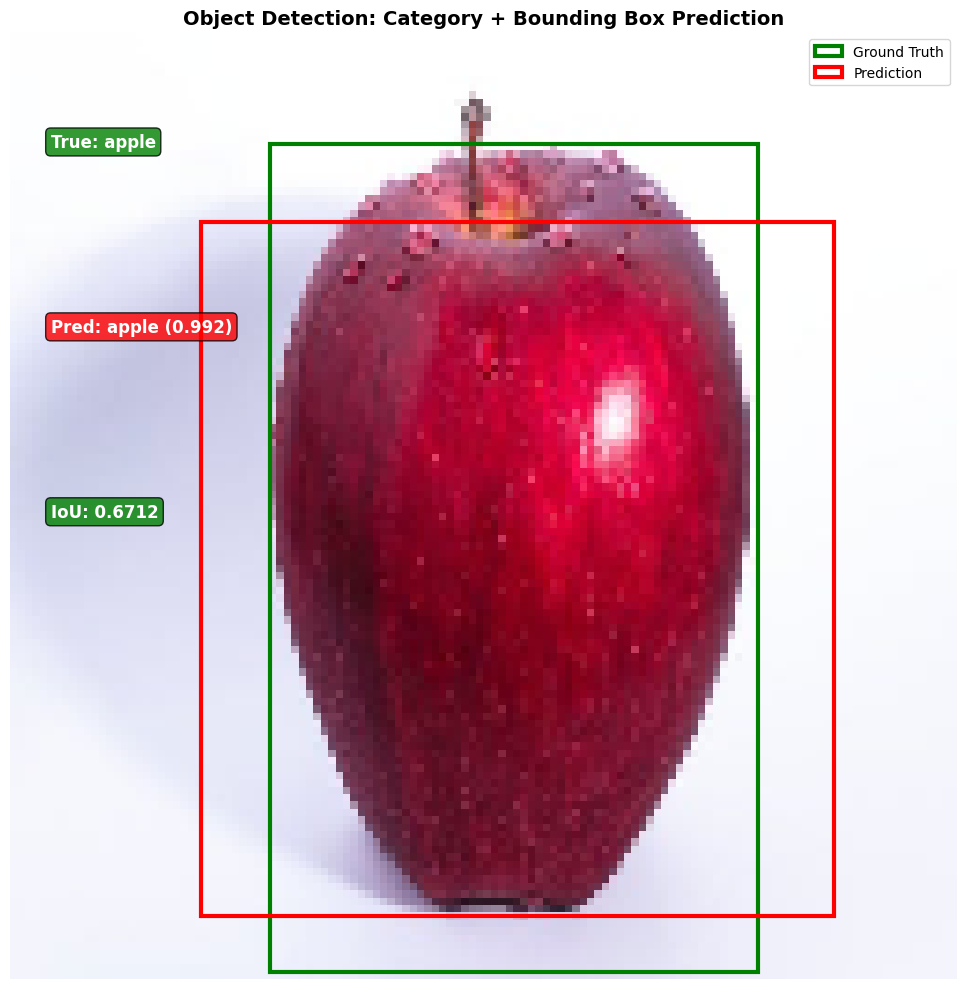

------------------------------------------------------------

Sample 2:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.2365, ymin=0.1082, xmax=0.7531, ymax=0.8726]
  Prediction:
    Category: apple (confidence: 0.9972)
    BBox: [xmin=0.2071, ymin=0.1428, xmax=0.7861, ymax=0.8623]
  Metrics:
    IoU Score: 0.8451
    Classification: ✓


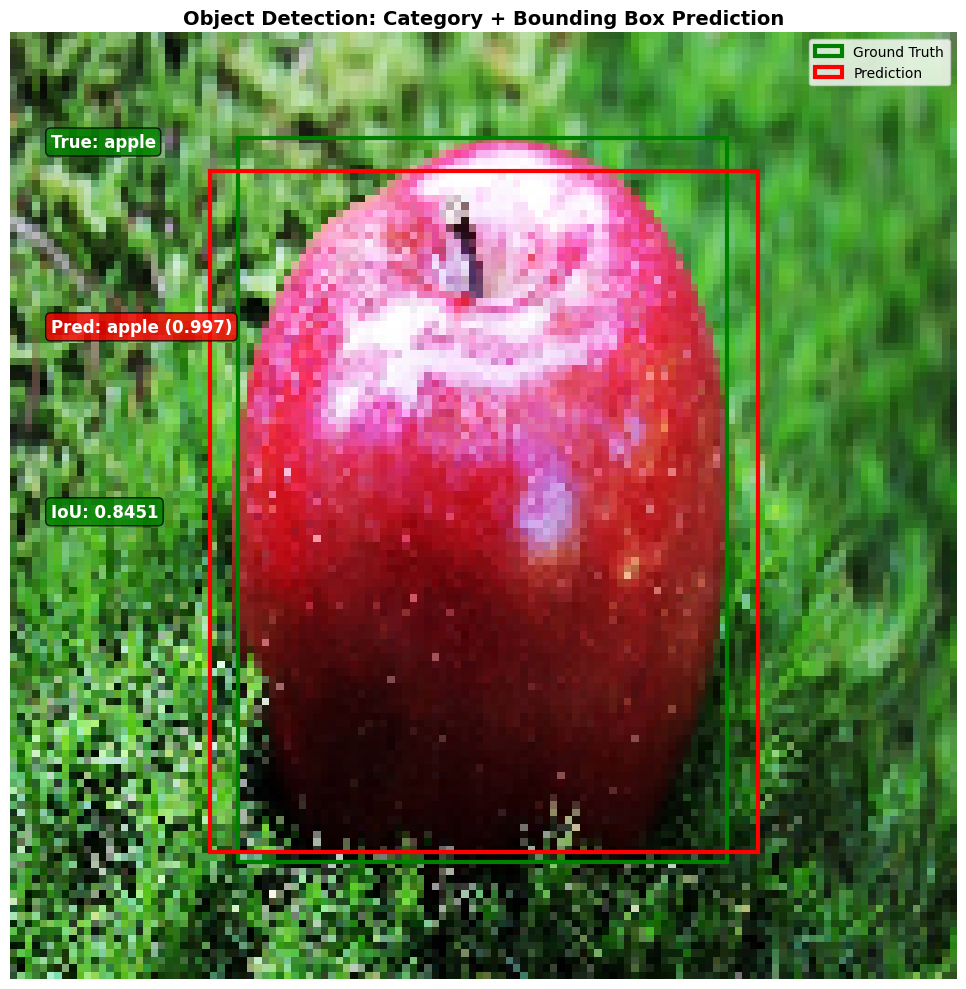

------------------------------------------------------------

Sample 3:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0320, ymin=0.0620, xmax=0.9791, ymax=0.9550]
  Prediction:
    Category: apple (confidence: 0.9992)
    BBox: [xmin=0.1457, ymin=0.1331, xmax=0.8530, ymax=0.9460]
  Metrics:
    IoU Score: 0.6797
    Classification: ✓


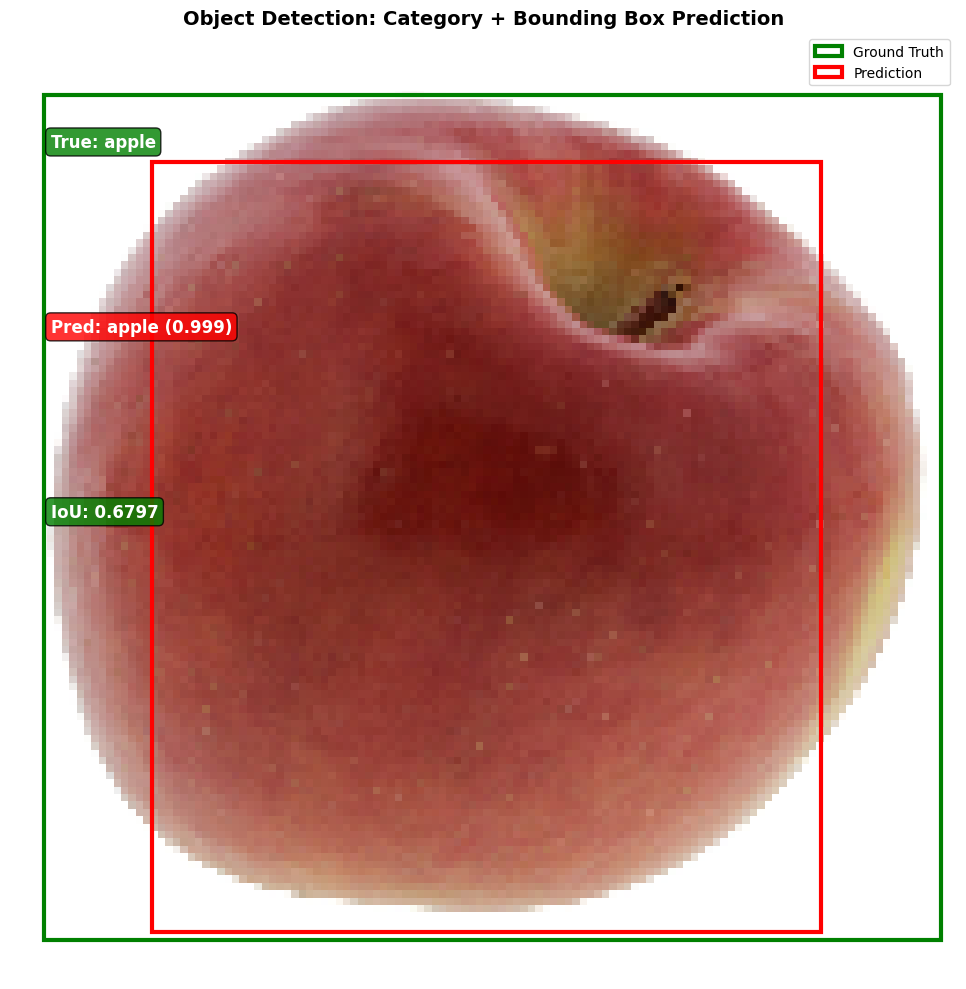

------------------------------------------------------------

Sample 4:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1828, ymin=0.2455, xmax=0.6152, ymax=0.9531]
  Prediction:
    Category: apple (confidence: 0.9996)
    BBox: [xmin=0.1313, ymin=0.0832, xmax=0.8826, ymax=0.9577]
  Metrics:
    IoU Score: 0.4657
    Classification: ✓


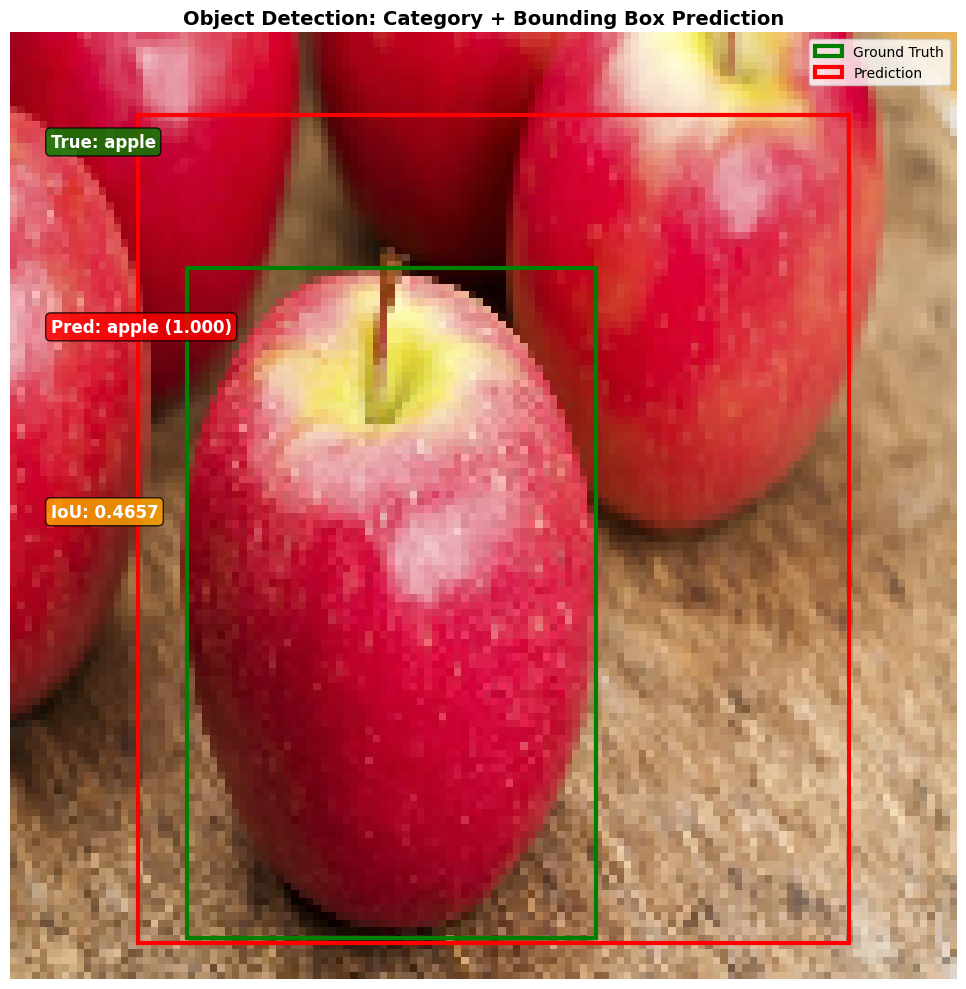

------------------------------------------------------------

Sample 5:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0896, ymin=0.2792, xmax=0.7458, ymax=0.9479]
  Prediction:
    Category: apple (confidence: 0.9931)
    BBox: [xmin=0.2253, ymin=0.1867, xmax=0.7741, ymax=0.8680]
  Metrics:
    IoU Score: 0.6053
    Classification: ✓


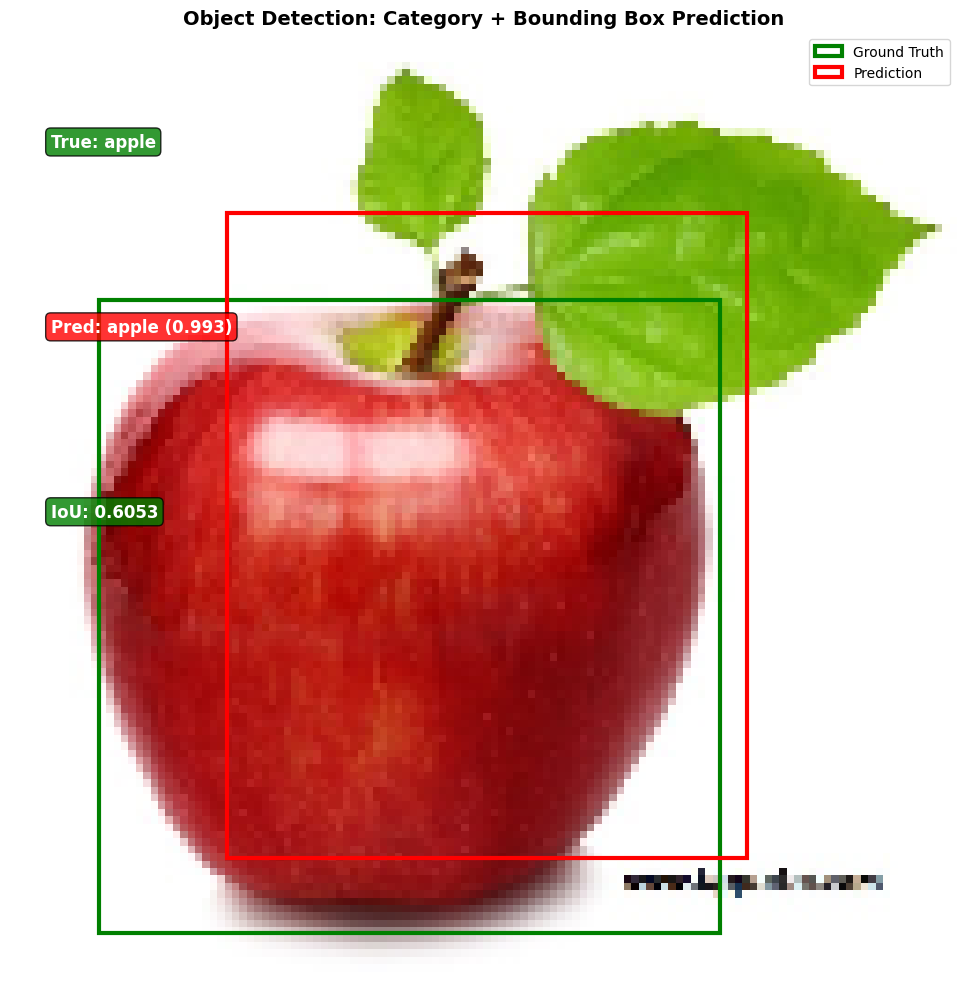

------------------------------------------------------------

Sample 6:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1862, ymin=0.3538, xmax=0.7408, ymax=0.9454]
  Prediction:
    Category: apple (confidence: 0.9568)
    BBox: [xmin=0.2242, ymin=0.1245, xmax=0.8820, ymax=0.9393]
  Metrics:
    IoU Score: 0.5385
    Classification: ✓


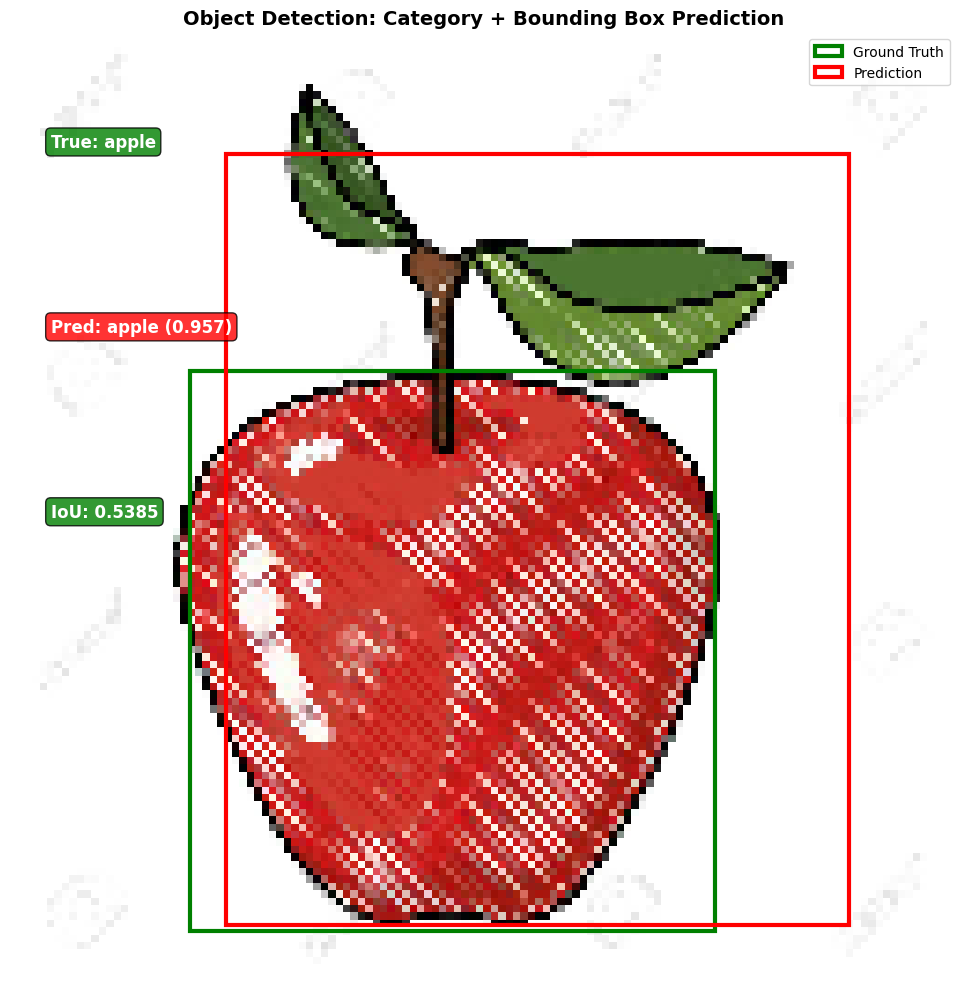

------------------------------------------------------------

Sample 7:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0596, ymin=0.1868, xmax=0.8715, ymax=0.9423]
  Prediction:
    Category: apple (confidence: 0.9995)
    BBox: [xmin=0.1425, ymin=0.1194, xmax=0.8708, ymax=0.9440]
  Metrics:
    IoU Score: 0.8290
    Classification: ✓


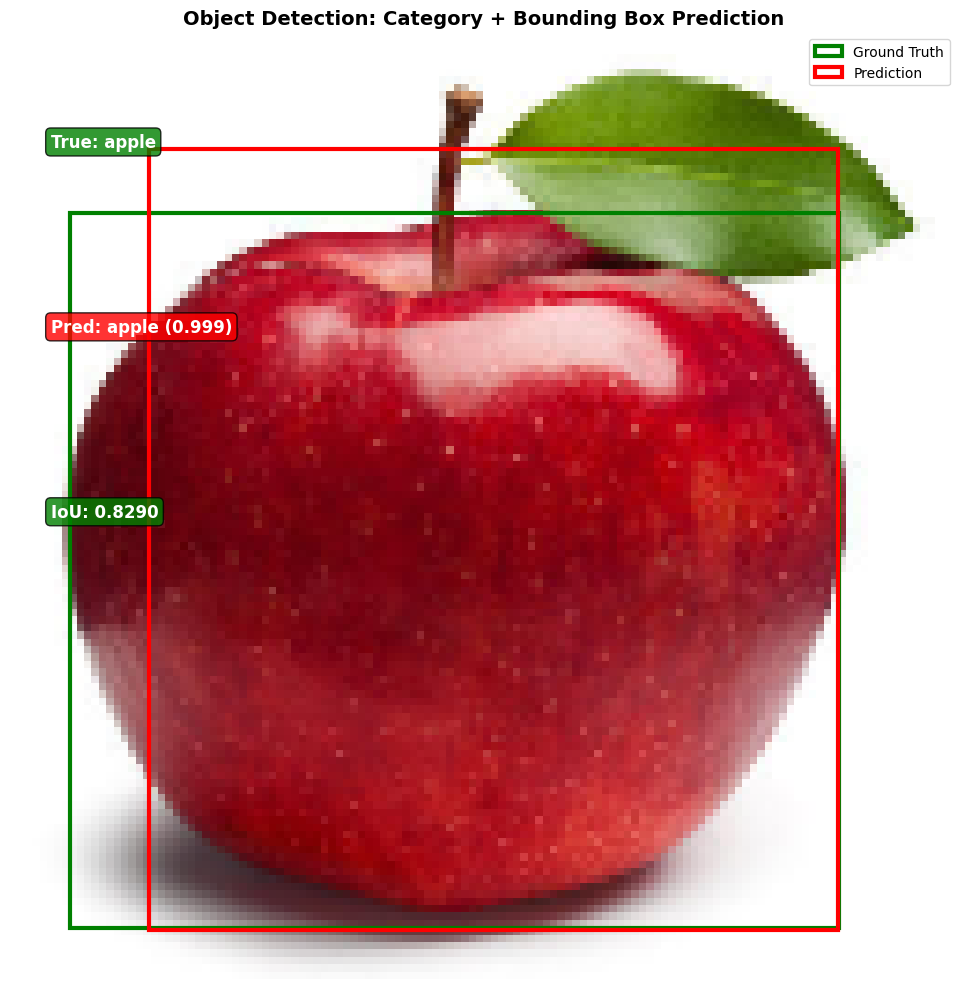

------------------------------------------------------------

Sample 8:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.2635, ymin=0.5106, xmax=0.4071, ymax=0.7482]
  Prediction:
    Category: apple (confidence: 0.5722)
    BBox: [xmin=0.2090, ymin=0.2133, xmax=0.8236, ymax=0.8772]
  Metrics:
    IoU Score: 0.0836
    Classification: ✓


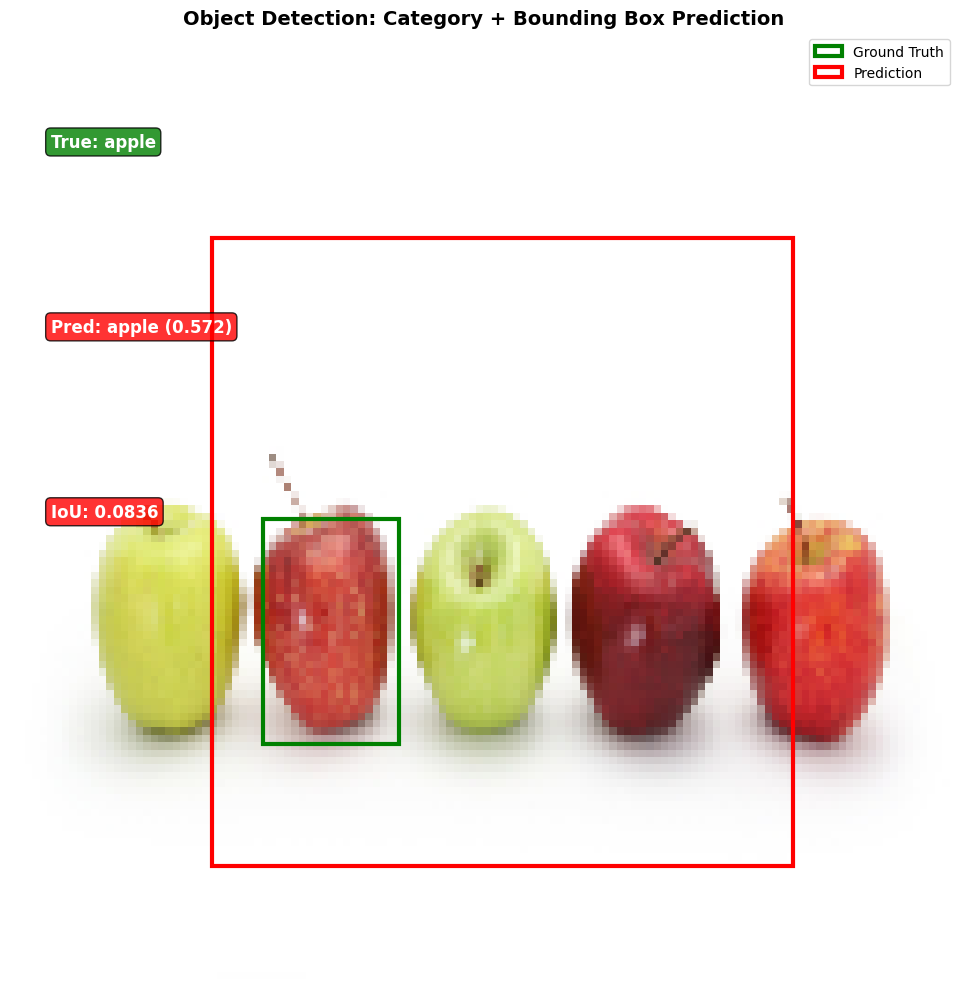

------------------------------------------------------------

Sample 9:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0013, ymin=0.0013, xmax=0.9925, ymax=0.9906]
  Prediction:
    Category: apple (confidence: 0.9999)
    BBox: [xmin=0.0920, ymin=0.0792, xmax=0.9088, ymax=0.9752]
  Metrics:
    IoU Score: 0.7464
    Classification: ✓


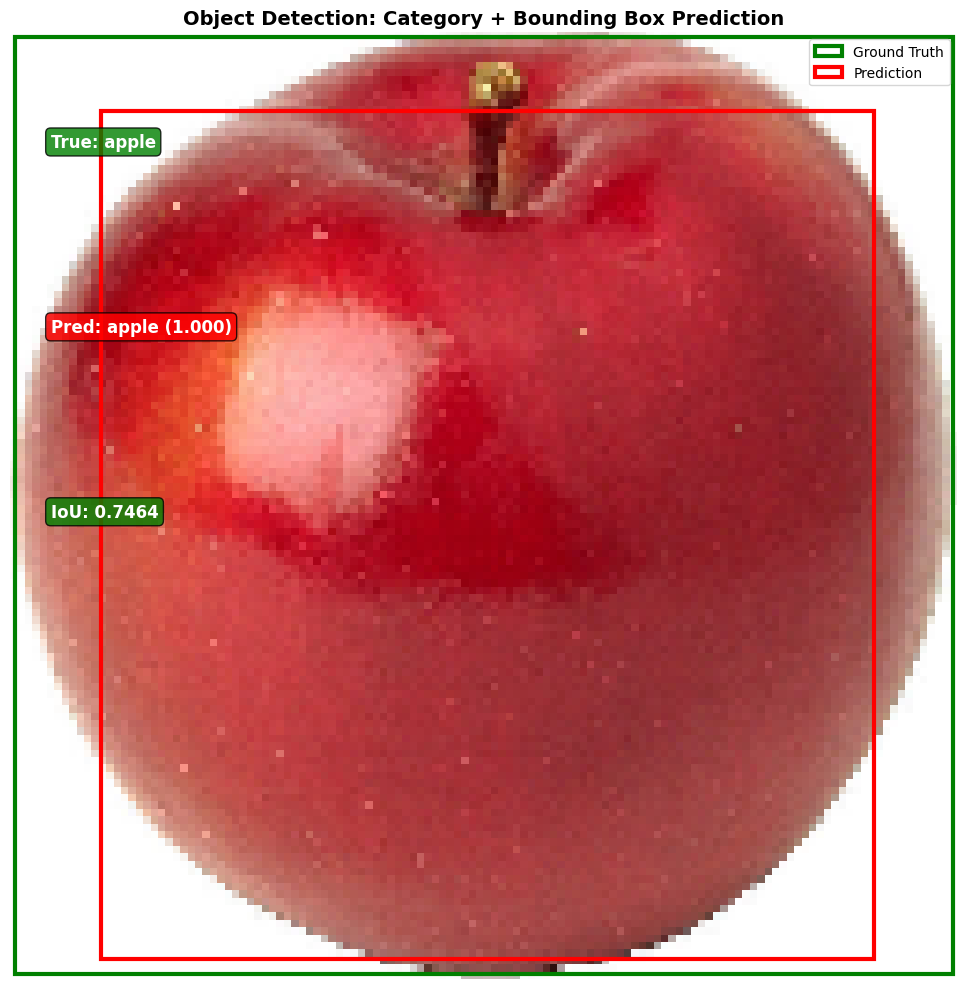

------------------------------------------------------------

Sample 10:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0753, ymin=0.1487, xmax=0.5694, ymax=0.8088]
  Prediction:
    Category: apple (confidence: 0.9970)
    BBox: [xmin=0.1747, ymin=0.1439, xmax=0.8025, ymax=0.9028]
  Metrics:
    IoU Score: 0.4808
    Classification: ✓


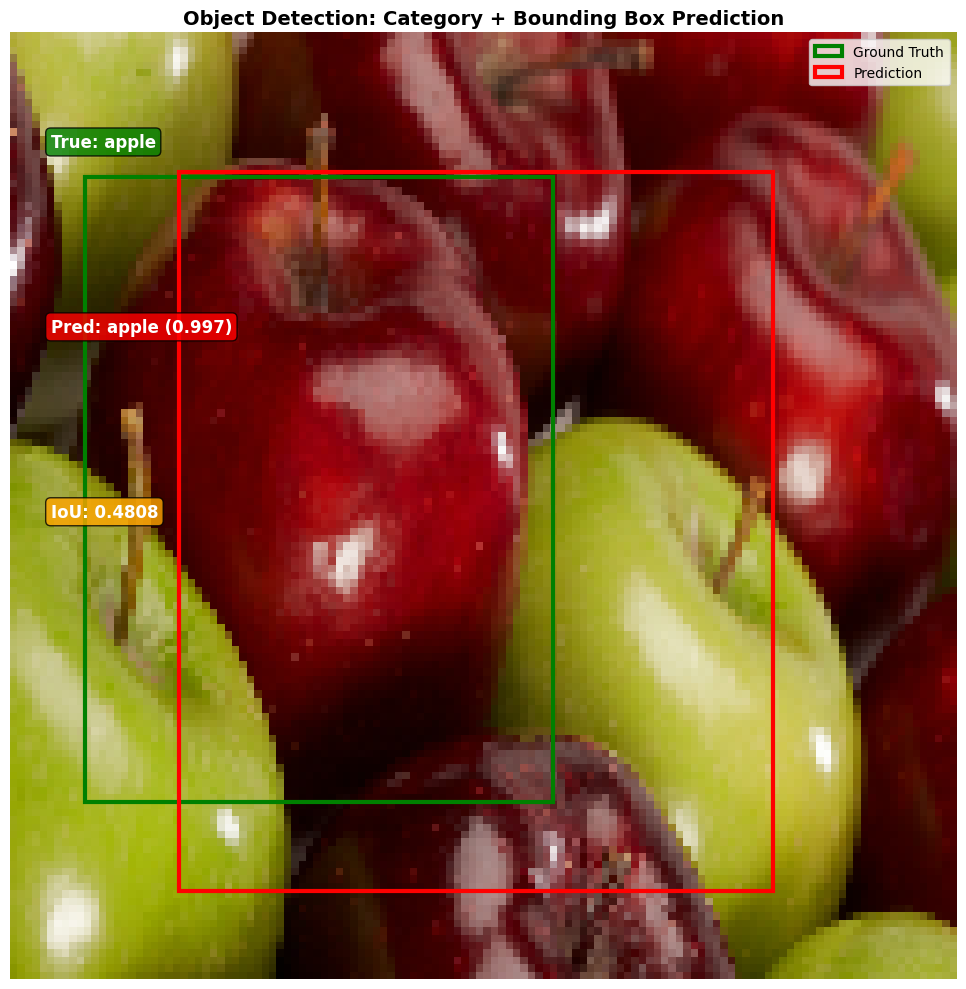

------------------------------------------------------------

Sample 11:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1562, ymin=0.2596, xmax=0.8774, ymax=0.8596]
  Prediction:
    Category: apple (confidence: 0.9944)
    BBox: [xmin=0.2172, ymin=0.2008, xmax=0.8045, ymax=0.8950]
  Metrics:
    IoU Score: 0.7221
    Classification: ✓


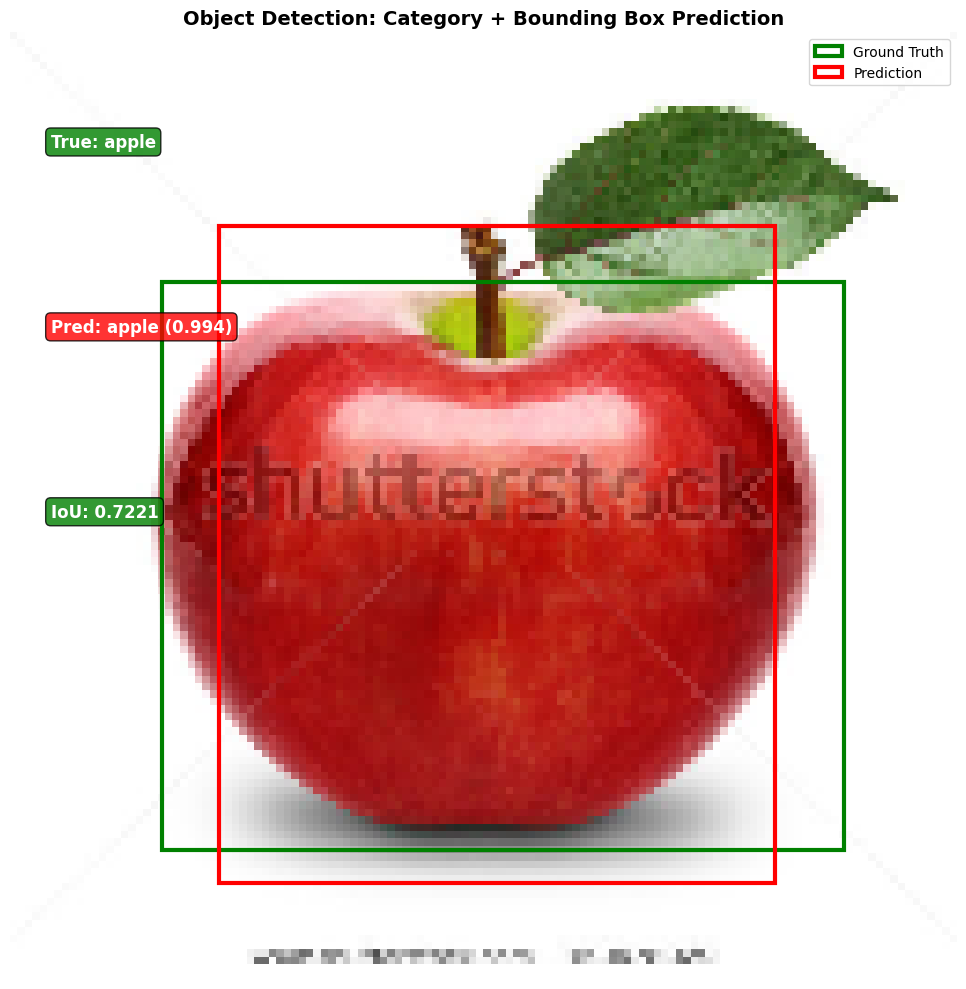

------------------------------------------------------------

Sample 12:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1760, ymin=0.1025, xmax=0.8300, ymax=0.9825]
  Prediction:
    Category: apple (confidence: 0.9874)
    BBox: [xmin=0.2221, ymin=0.1710, xmax=0.7522, ymax=0.8338]
  Metrics:
    IoU Score: 0.6105
    Classification: ✓


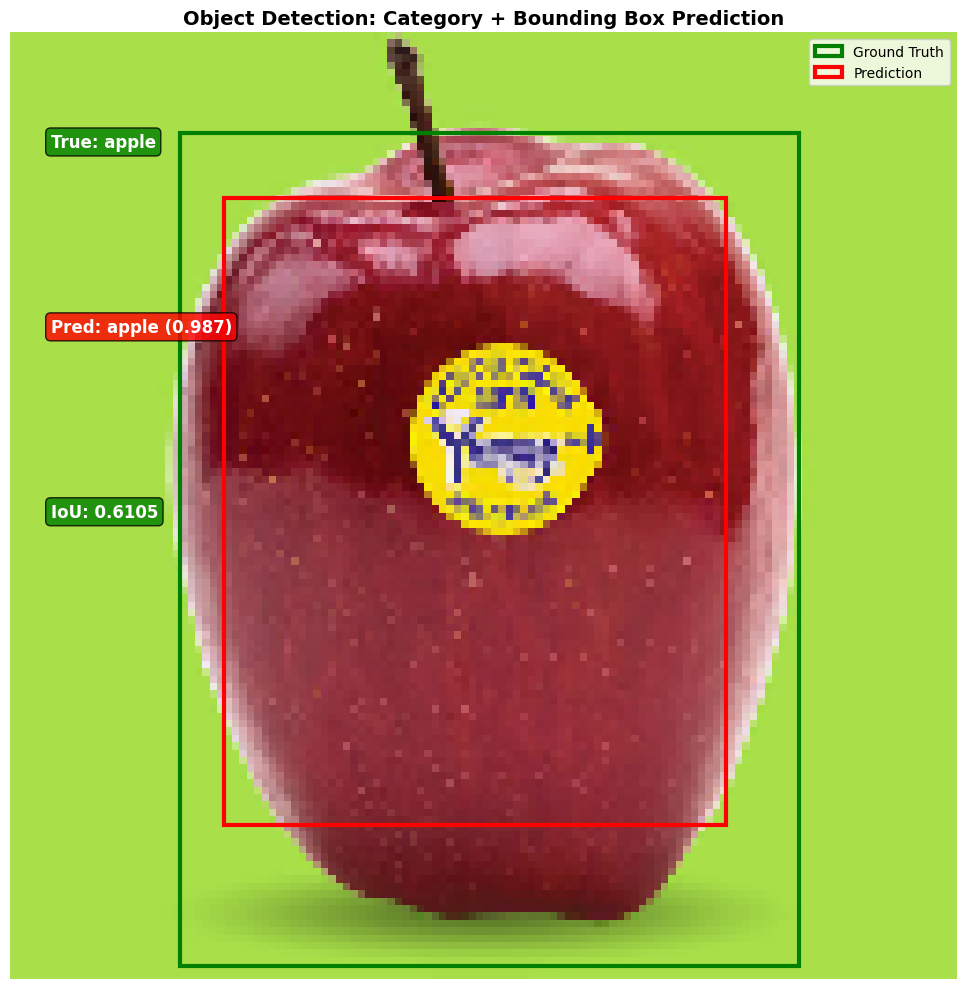

------------------------------------------------------------

Sample 13:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0467, ymin=0.2276, xmax=0.9253, ymax=0.9897]
  Prediction:
    Category: apple (confidence: 0.9992)
    BBox: [xmin=0.1510, ymin=0.1384, xmax=0.8599, ymax=0.9385]
  Metrics:
    IoU Score: 0.6877
    Classification: ✓


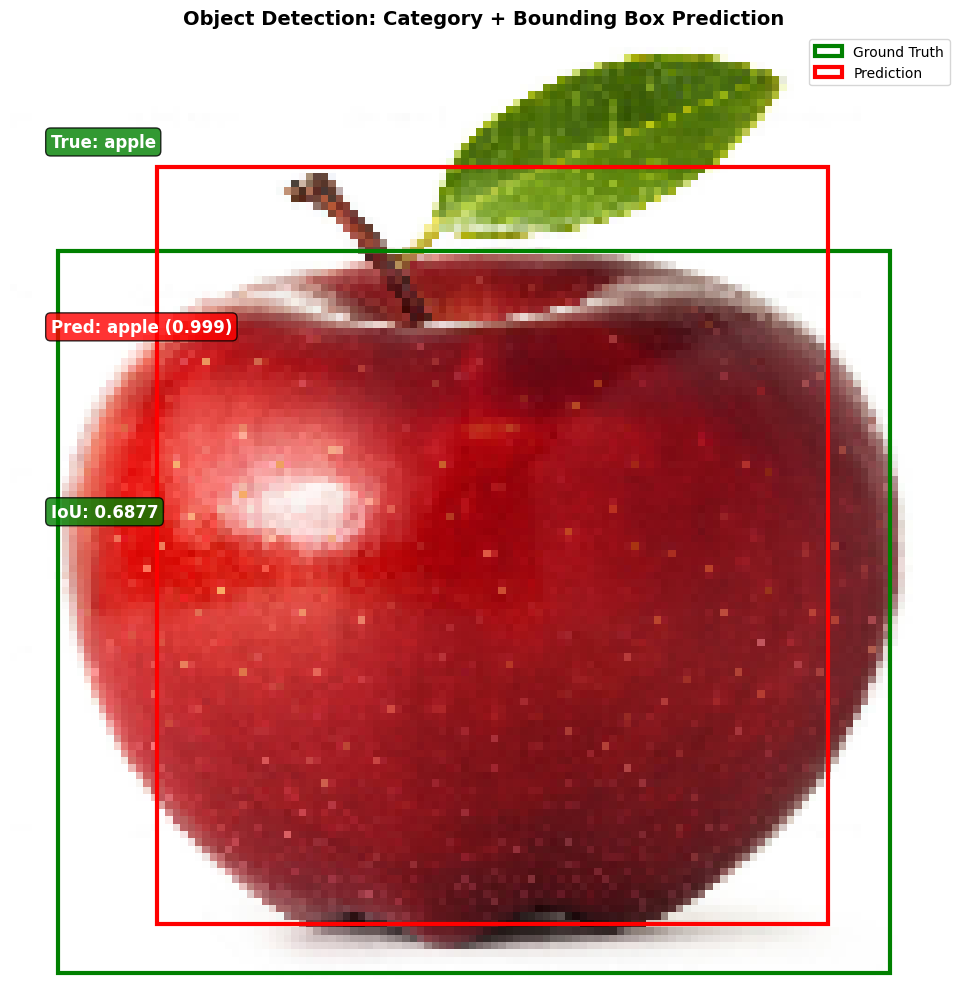

------------------------------------------------------------

Sample 14:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.2583, ymin=0.2100, xmax=0.7550, ymax=0.8720]
  Prediction:
    Category: apple (confidence: 0.9905)
    BBox: [xmin=0.2239, ymin=0.2125, xmax=0.8399, ymax=0.9157]
  Metrics:
    IoU Score: 0.7540
    Classification: ✓


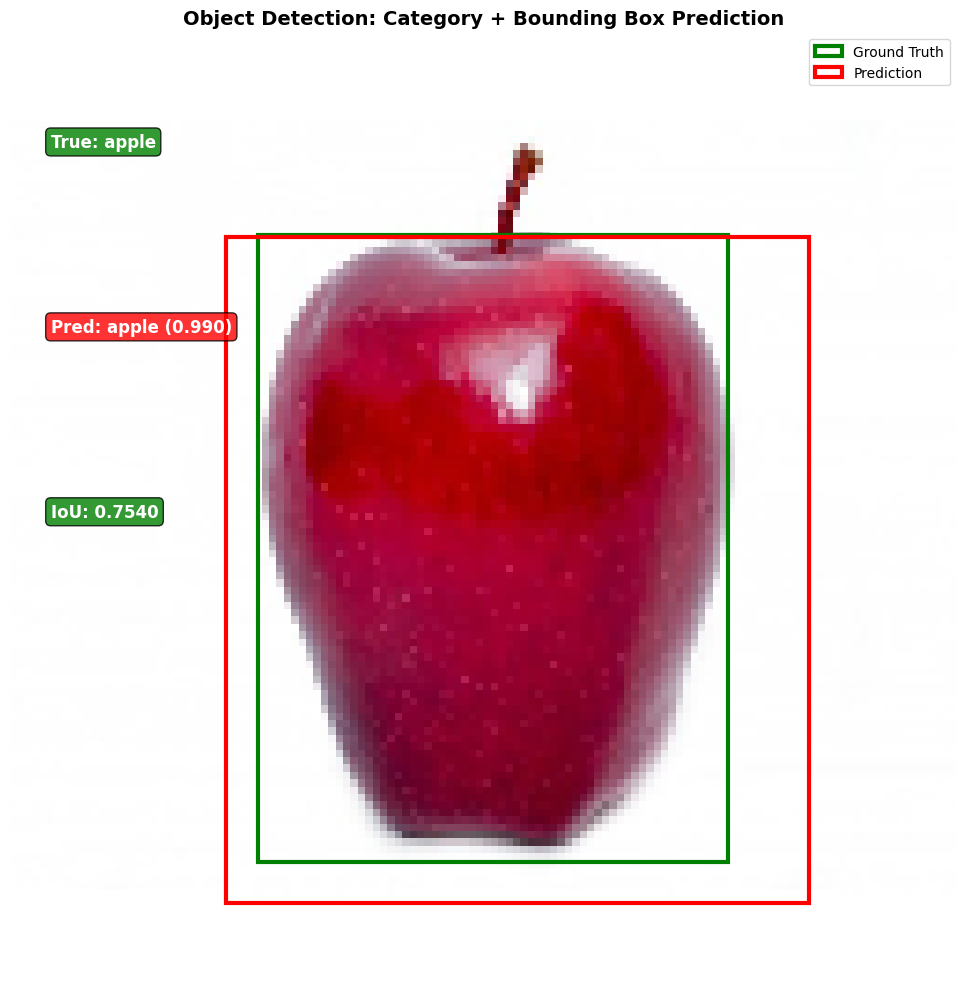

------------------------------------------------------------

Sample 15:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1069, ymin=0.2542, xmax=0.8903, ymax=0.9944]
  Prediction:
    Category: apple (confidence: 0.9985)
    BBox: [xmin=0.1604, ymin=0.1352, xmax=0.8312, ymax=0.9389]
  Metrics:
    IoU Score: 0.6963
    Classification: ✓


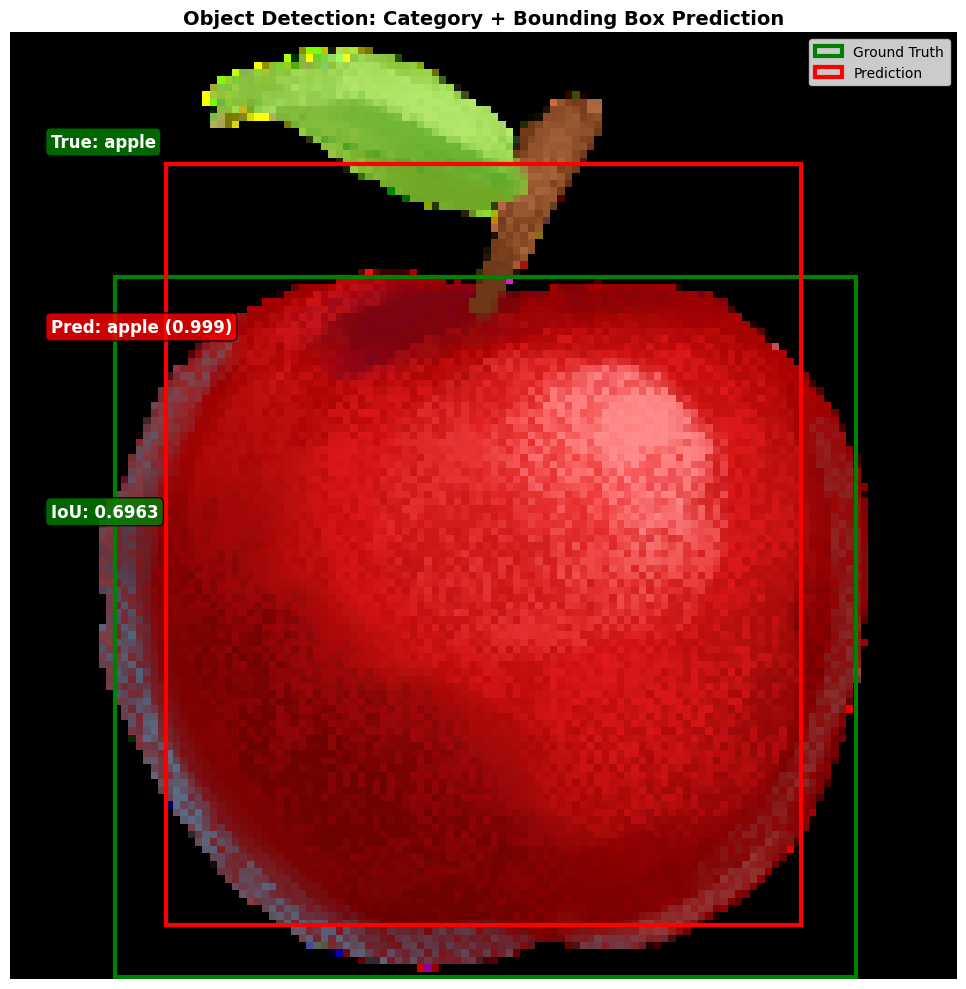

------------------------------------------------------------

Sample 16:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.2367, ymin=0.2620, xmax=0.5833, ymax=0.7162]
  Prediction:
    Category: apple (confidence: 0.9902)
    BBox: [xmin=0.2534, ymin=0.1861, xmax=0.7542, ymax=0.8285]
  Metrics:
    IoU Score: 0.4549
    Classification: ✓


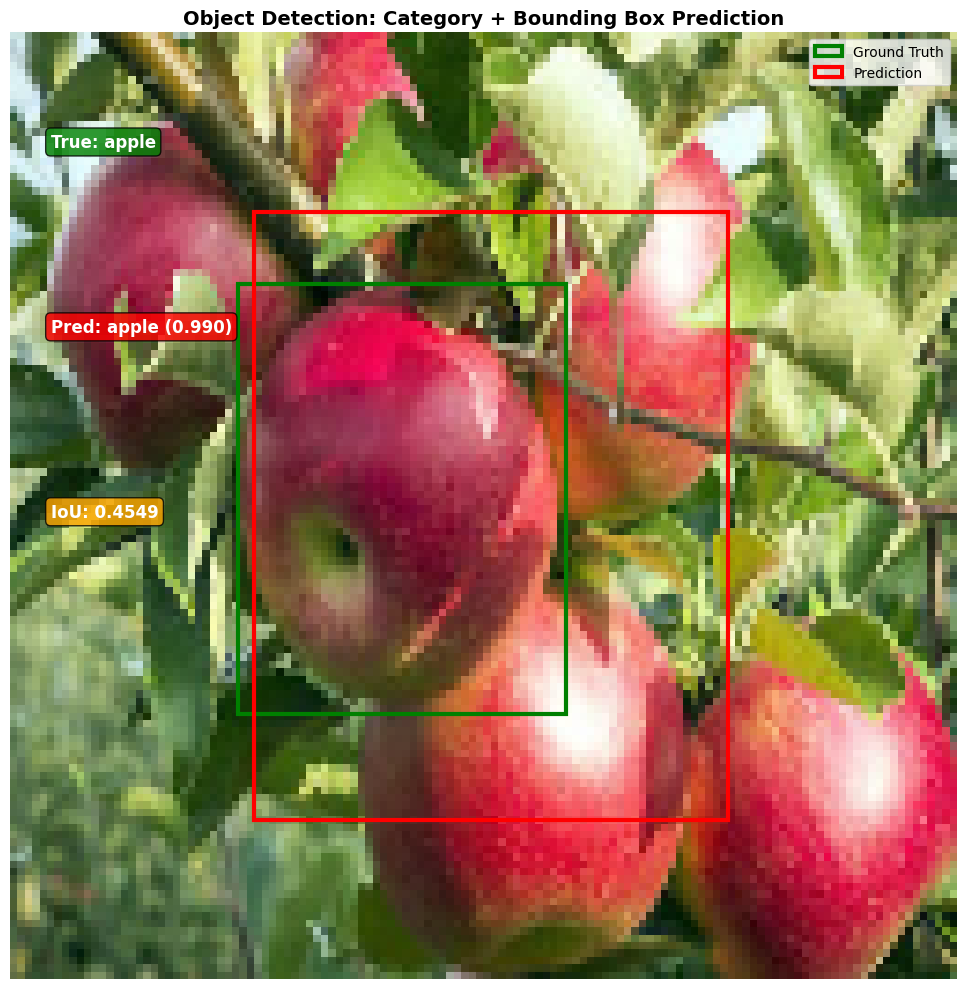

------------------------------------------------------------

Sample 17:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.0286, ymin=0.0229, xmax=0.9829, ymax=0.9600]
  Prediction:
    Category: apple (confidence: 0.9856)
    BBox: [xmin=0.1828, ymin=0.1788, xmax=0.8154, ymax=0.9080]
  Metrics:
    IoU Score: 0.5158
    Classification: ✓


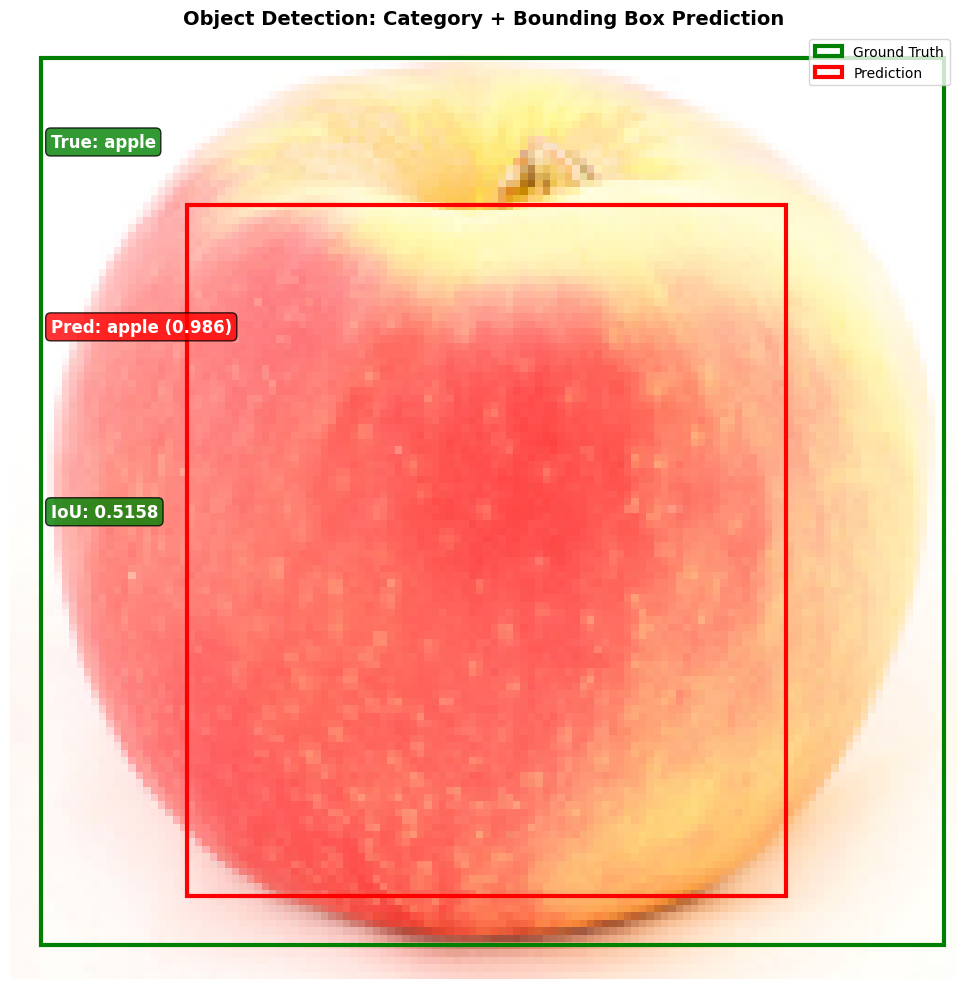

------------------------------------------------------------

Sample 18:
  Ground Truth:
    Category: banana
    BBox: [xmin=0.0967, ymin=0.0306, xmax=0.8200, ymax=0.9667]
  Prediction:
    Category: banana (confidence: 0.9775)
    BBox: [xmin=0.1624, ymin=0.2138, xmax=0.8225, ymax=0.8609]
  Metrics:
    IoU Score: 0.6270
    Classification: ✓


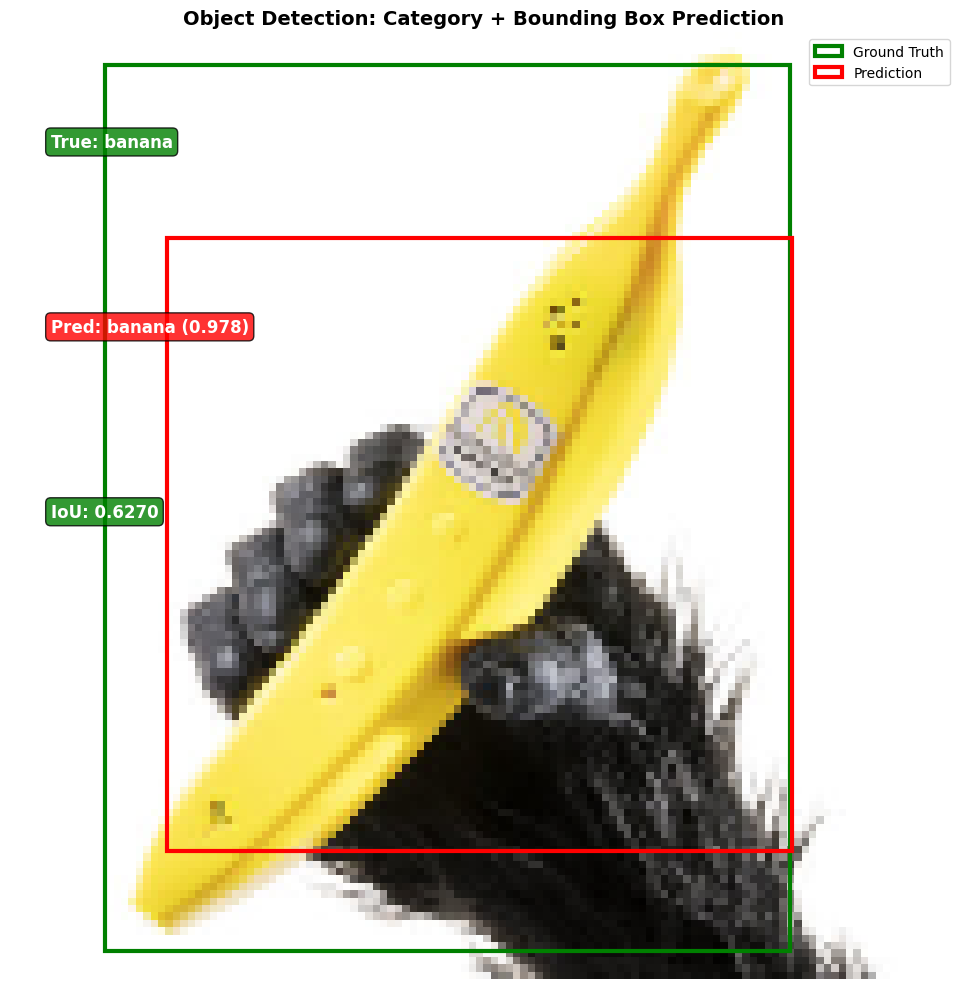

------------------------------------------------------------

Sample 19:
  Ground Truth:
    Category: banana
    BBox: [xmin=0.0346, ymin=0.2861, xmax=0.9477, ymax=0.8256]
  Prediction:
    Category: banana (confidence: 0.9805)
    BBox: [xmin=0.1349, ymin=0.1682, xmax=0.8726, ymax=0.8688]
  Metrics:
    IoU Score: 0.6508
    Classification: ✓


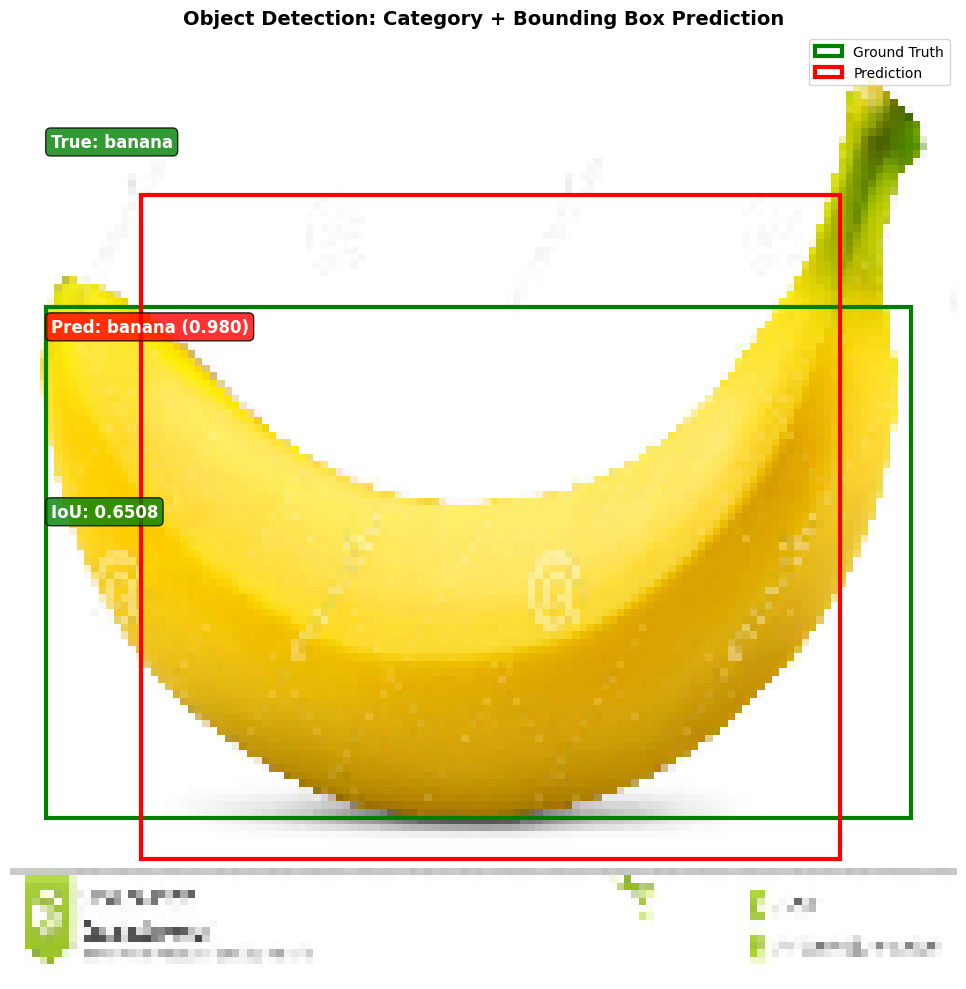

------------------------------------------------------------

Sample 20:
  Ground Truth:
    Category: apple
    BBox: [xmin=0.1283, ymin=0.1233, xmax=0.9000, ymax=0.8633]
  Prediction:
    Category: apple (confidence: 0.9375)
    BBox: [xmin=0.2625, ymin=0.2195, xmax=0.7273, ymax=0.8220]
  Metrics:
    IoU Score: 0.4904
    Classification: ✓


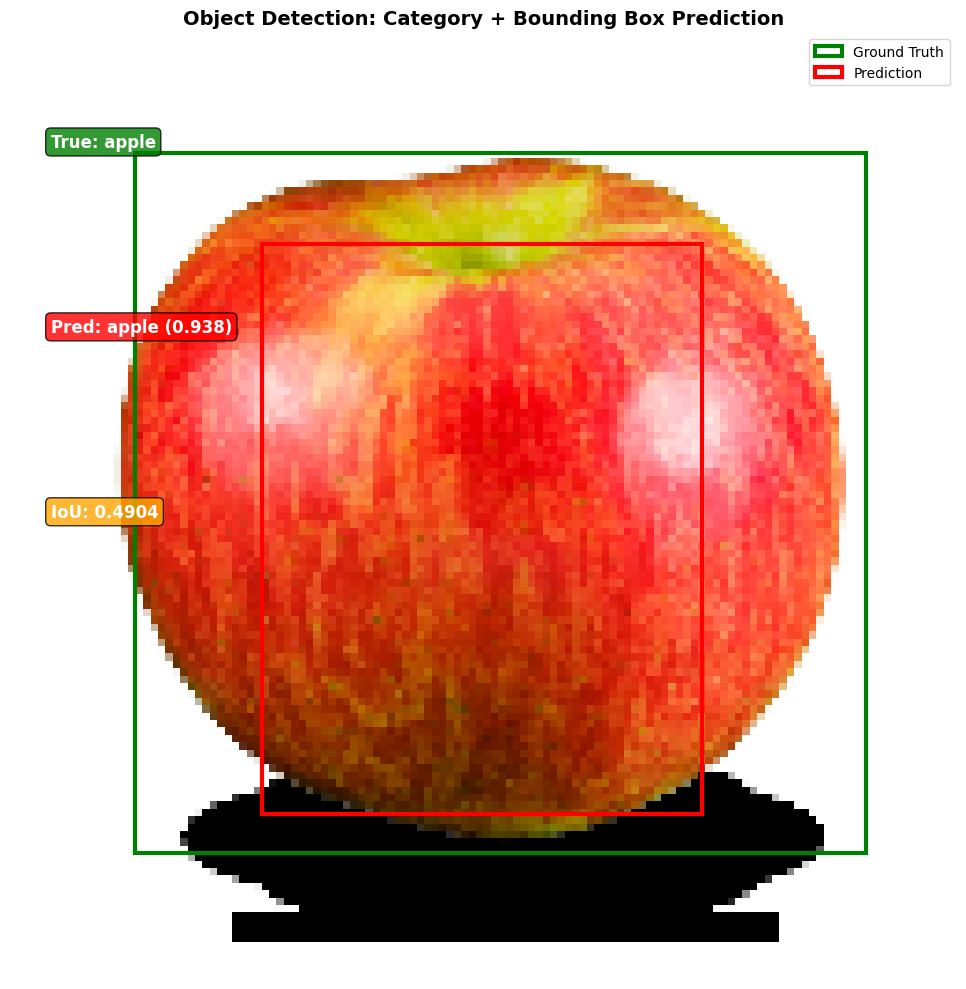

------------------------------------------------------------

Overall Results:
Classification Accuracy: 1.0000
Average IoU: 0.6077
Good Detections (IoU > 0.5): 0.7500


In [12]:
# Evaluate and visualize results
if len(X_test) > 0:
    evaluate_model(detector, X_test, y_test_class, y_test_bbox)
    predict_and_visualize(detector, X_test, y_test_class, y_test_bbox, num_samples=min(20,len(X_test)))
else:
    print("No test data available for evaluation")

#### Save the best model

In [13]:
# Save the final trained model
detector.model.save('fruit_object_detector.h5')
print("Model saved as 'fruit_object_detector.h5'")

Model saved as 'fruit_object_detector.h5'
